In [14]:
# import necessary functions
%load_ext autoreload
%autoreload 2

In [15]:
%matplotlib widget

In [16]:
from statesim.model.statespace import Linear, Nonlinear
from statesim.simulator import ContinuousSimulator, DiscreteSimulator
from statesim.system.cartpole import CartPole
from statesim.system.coupled_msd import CoupledMsd
from statesim.system.inverted_pendulum import InvertedPendulum
from statesim.analysis.plot_simulation_results import (
    plot_states,
    plot_outputs,
    plot_inputs,
    plot_comparison,
)
from statesim.generate.input import random_static_input
from statesim.noise import NoiseGeneration
import numpy as np

step_size = 0.5

# Cartpole

In [ ]:
system = CartPole(mu_c=0, mu_p=0.01)
x_bar = np.array([[0], [0], [np.pi], [0]])
A_sym, B_sym = system.get_linearization()
A, B = system.evaluate_linearization(
    A_sym=A_sym, B_sym=B_sym, x_bar=x_bar, u_bar=np.array([[0]])
)
print(f'A_lin: \n{A} \n B_lin: \n{B}')
x0 = np.array([[0], [0], [0.1], [0]])

lin_model = Linear(
    A=A,
    B=B,
    C=np.array([[0, 0, 1, 0]]),
    D=np.array([[0]]),
)

nl_model = Nonlinear(
    f=system.state_dynamics, g=system.output_function, nx=4, nu=1, ny=1
)

nx = A.shape[0]
A_d = A * step_size + np.eye(nx)
B_d = B * step_size
C_d = np.array([[0, 0, 1, 0]])
D_d = np.array([[0]])

# Inverted Pendulum

In [33]:
system = InvertedPendulum(mu_p=0.01)
x_bar = np.array([[np.pi], [0]])
A_sym, B_sym = system.get_linearization()
A, B = system.evaluate_linearization(
    A_sym=A_sym, B_sym=B_sym, x_bar=x_bar, u_bar=np.array([[0]])
)
print(f'A_lin: \n{A} \n B_lin: \n{B}')
x0 = np.array([[np.pi + 0.8], [0]])

lin_model = Linear(
    A=A,
    B=B,
    C=np.array([[1, 0]]),
    D=np.array([[0]]),
)

nl_model = Nonlinear(
    f=system.state_dynamics, g=system.output_function, nx=2, nu=1, ny=1
)

nx = A.shape[0]
A_d = A * step_size + np.eye(nx)
B_d = B * step_size
C_d = np.array([[1, 0]])
D_d = np.array([[0]])

A_lin: 
[[  0.     1.  ]
 [-19.62  -0.4 ]] 
 B_lin: 
[[ 0.]
 [40.]]


# MSD

In [17]:
x_bar = np.zeros(shape=(8, 1))
system = CoupledMsd()
A_sym, B_sym = system.get_linearization()
A_c, B_c = system.evaluate_linearization(
    A_sym=A_sym,
    B_sym=B_sym,
    x_bar=x_bar,
    u_bar=np.array([[0]]),
)
C_c = np.zeros(shape=(1, 8))
C_c[0, -2] = 1
D_c = np.array([[0]])

x0 = np.zeros(shape=(8, 1))

lin_model = Linear(
    A=A_c,
    B=B_c,
    C=C_c,
    D=D_c,
)

nl_model = Nonlinear(
    f=system.state_dynamics, g=system.output_function, nx=8, nu=1, ny=1
)


A_d = A_c * step_size + np.eye(system.nx)
B_d = B_c * step_size
C_d = C_c
D_d = D_c

print(D_d)

[[0]]


## Simulation

In [23]:
T_end = 100
N = int(T_end / step_size)
us = [np.array([[u]]) for u in np.zeros(N)]
us = random_static_input(
    N=N, nu=1, amplitude_range=(-0.2, 0.2), frequency_range=(10, 40)
)

noise_config = NoiseGeneration('gaussian', 0.0, 0.01)
sim = ContinuousSimulator(T=T_end, step_size=step_size)
lin_res = sim.simulate(
    model=lin_model, initial_state=x0, input=us, name='lin', x_bar=x_bar
)
nl_res = sim.simulate(
    model=nl_model,
    initial_state=x0,
    input=us,
    name='non lin',
    noise_config=noise_config,
)

lin_model_d = Linear(
    A=A_d,
    B=B_d,
    C=C_d,
    D=D_d,
)

sim_d = DiscreteSimulator(T=T_end, step_size=step_size)
lin_res_d = sim_d.simulate(
    model=lin_model_d, initial_state=x0, input=us, name='lin disc', x_bar=x_bar
)

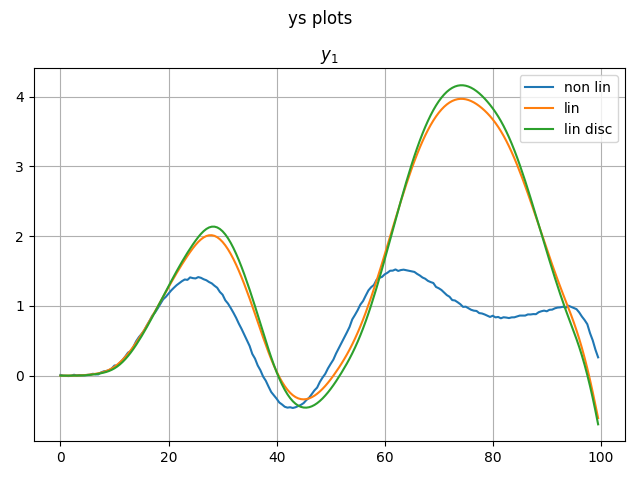

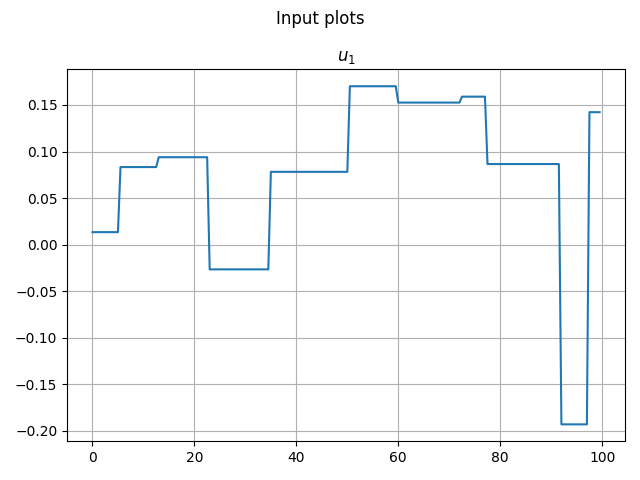

In [24]:
plot_comparison(results=[nl_res, lin_res, lin_res_d], type='ys')
# plot_outputs(result=nl_res)
plot_inputs(result=lin_res)